In [13]:
import pandas as pd
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler   
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV

In [14]:
# Getting the block info dataset
dataset = pd.read_csv('./datasets/dataset.csv')

In [15]:
dataset.columns

Index(['Unnamed: 0', 'block_base_fee', 'difficulty', 'gas_limit', 'gas_used',
       'number', 'size', 'time', 'total_difficulty', '0.25 Tip (Gwei)',
       '0.75 Tip (Gwei)', 'AVG Tip (Gwei)', 'Block Base Fees (ETH)',
       'Block Tips (ETH)', 'Legacy TX count', 'Max Tip (Gwei)',
       'Median Tip (Gwei)', 'Min Tip (Gwei)', 'TX count', 'block_number'],
      dtype='object')

In [16]:
# 2317337 blocks 
len(dataset.index)

2317337

In [17]:
# Data type and column name transformantions 
#dataset=dataset[dataset['block_number']<=13165745]
dataset=dataset[dataset['block_number']<=13062158]
dataset = dataset.drop(columns=['block_number'])
dataset = dataset.drop(columns=['Unnamed: 0'])
dataset = dataset.rename(columns={"0.25 Tip (Gwei)":"Q1_tip", "0.75 Tip (Gwei)":"Q3_tip", "AVG Tip (Gwei) ":"avg_tip", "Block Base Fees (ETH)":"block_base_fees_eth", "Block Tips (ETH)":"block_tips_eth", "Max Tip (Gwei)": "max_tip", "Median Tip (Gwei)": "median_tip", "Min Tip (Gwei)":"min_tip","AVG Tip (Gwei)":"avg_tip", "Legacy TX count":"legacy_tx","TX count":"tx_count"})
dataset['time'] = pd.to_datetime(dataset['time'])
dataset['time'] = dataset['time'].dt.strftime('%Y-%m-%d %H:%M:00')
#dataset['time'] = dataset['time'].dt.floor('Min')
dataset['time'] = pd.to_datetime(dataset['time'])

In [18]:
# eth price dataset from Binance
eth_price = pd.read_csv('./datasets/eth_price.csv')
eth_price

,Unnamed: 0,datetime,eth_price
0,0,2021-08-05 12:33:00,2615.68
1,1,2021-08-05 12:34:00,2608.04
2,2,2021-08-05 12:35:00,2615.22
3,3,2021-08-05 12:36:00,2620.99
4,4,2021-08-05 12:37:00,2618.12
...,...,...,...
525995,525995,2022-08-05 19:08:00,1667.74
525996,525996,2022-08-05 19:09:00,1668.26
525997,525997,2022-08-05 19:10:00,1669.79
525998,525998,2022-08-05 19:11:00,1670.99


In [19]:
# Data type and column name transformantions 
eth_price['datetime'] = pd.to_datetime(eth_price['datetime'])
#eth_price = eth_price[eth_price['datetime'] <= '2022-08-05 12:33:00']
#eth_price = eth_price[eth_price['datetime'] <= '2021-09-05 12:33:00']
eth_price = eth_price[eth_price['datetime'] <= '2021-08-20 12:34:00']
eth_price = eth_price.rename(columns={'datetime': 'time'})
eth_price = eth_price.drop(columns=['Unnamed: 0'])
eth_price = eth_price.drop_duplicates(subset=['time'])

# Join dataset and eth price
ds_aux = dataset.merge(eth_price, on='time', how='left', indicator=True)


# There are gaps in the Binance API, so we get the last known eth price value and we insert that into empty timestamps
empty_values = ds_aux[ds_aux['_merge'] == 'left_only']
for row in empty_values.iterrows():
    i = 1
    price = 0
    while price == 0:
        if math.isnan(ds_aux.loc[row[0]-i]['eth_price']):
            i=i+1
        else:
            price=ds_aux.loc[row[0]-i]['eth_price']
    ds_aux.at[row[0],'eth_price'] = price

In [20]:
dataset = ds_aux
dataset = dataset.drop(columns=['_merge'])
# Drop empty blocks with no tip data 
dataset = dataset.dropna()
dataset = dataset.drop(columns=['total_difficulty'])

dataset

,block_base_fee,difficulty,gas_limit,gas_used,number,size,time,Q1_tip,Q3_tip,avg_tip,block_base_fees_eth,block_tips_eth,legacy_tx,max_tip,median_tip,min_tip,tx_count,eth_price
0,1000000000,7742494561645080,30029122,30025257,12965000,584,2021-08-05 12:33:00,22.000000,32.000000,35.122037,0.030025,0.813216,259.0,1558.000000,25.000000,22.000000,259.0,2615.68
1,1124967822,7742495635386904,29999798,29985144,12965001,579,2021-08-05 12:33:00,25.875032,44.900606,33.106784,0.033732,0.926795,256.0,98.875032,28.380162,21.375032,257.0,2615.68
2,1265451421,7738716193681762,29970503,29950343,12965002,577,2021-08-05 12:34:00,20.734549,25.484549,24.922555,0.037901,0.712779,321.0,77.734549,20.734549,20.734549,321.0,2608.04
3,1423420054,7742495937440032,29941236,29933895,12965003,586,2021-08-05 12:34:00,25.576580,34.876580,31.892835,0.042609,0.965993,257.0,128.576580,26.576580,0.000000,265.0,2608.04
4,1601260312,7742497011181856,29911998,29895283,12965004,579,2021-08-05 12:34:00,31.273740,45.398740,49.536780,0.047870,1.400710,276.0,498.398740,45.398740,28.098740,280.0,2608.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95778,24605240827,7854904080127467,30000000,13481142,13062154,587,2021-08-20 12:32:00,1.500000,2.875000,5.971461,0.331707,0.053422,74.0,64.933368,1.567929,1.000000,166.0,3220.06
95779,24293808604,7858741629993989,29970705,23787488,13062155,576,2021-08-20 12:32:00,1.500000,10.581191,8.799701,0.577889,0.129766,149.0,207.806191,3.046066,0.000000,258.0,3220.06
95780,26077528860,7847231948918077,29999972,20430062,13062156,583,2021-08-20 12:33:00,3.922471,13.922471,10.689920,0.532766,0.172252,305.0,277.991471,5.922471,0.000000,305.0,3219.10
95781,27257554658,7851065752626782,30029267,29758586,13062157,586,2021-08-20 12:33:00,1.500000,6.030852,9.994718,0.811146,0.230828,141.0,991.289630,3.742445,0.000000,394.0,3219.10


In [21]:
# Drop not relevant columns
dataset = dataset.drop(columns=['time','number'])

def reorder_dataset(dataset, n):
    
    ds = dataset.copy()
    for i in range (1,n+1):
        ds['block_base_fee_'+str(i)] = np.nan
        ds['difficulty_'+str(i)] = np.nan
        ds['gas_limit_'+str(i)] = np.nan
        ds['gas_used_'+str(i)] = np.nan
        ds['size_'+str(i)] = np.nan
        ds['Q1_tip_'+str(i)] = np.nan
        ds['Q3_tip_'+str(i)] = np.nan
        ds['avg_tip_'+str(i)] = np.nan
        ds['block_base_fees_eth_'+str(i)] = np.nan
        ds['block_tips_eth_'+str(i)] = np.nan
        ds['max_tip_'+str(i)] = np.nan
        ds['median_tip_'+str(i)] = np.nan
        ds['eth_price_'+str(i)] = np.nan

    for i in range (1,n+1):        
        ds['block_base_fee_'+str(i)] = ds['block_base_fee'].shift(i)
        ds['difficulty_'+str(i)] = ds['difficulty'].shift(i)
        ds['gas_limit_'+str(i)] = ds['gas_limit'].shift(i)
        ds['gas_used_'+str(i)] = ds['gas_used'].shift(i)
        ds['size_'+str(i)] = ds['size'].shift(i)
        ds['Q1_tip_'+str(i)] = ds['Q1_tip'].shift(i)
        ds['Q3_tip_'+str(i)] = ds['Q3_tip'].shift(i)
        ds['avg_tip_'+str(i)] = ds['avg_tip'].shift(i)
        ds['block_base_fees_eth_'+str(i)] = ds['block_base_fees_eth'].shift(i)
        ds['block_tips_eth_'+str(i)] = ds['block_tips_eth'].shift(i)
        ds['max_tip_'+str(i)] = ds['max_tip'].shift(i)
        ds['median_tip_'+str(i)] = ds['median_tip'].shift(i)
        ds['eth_price_'+str(i)] = ds['eth_price'].shift(i)
    
    return ds

dataset_n1 = reorder_dataset(dataset,1)
dataset_n3 = reorder_dataset(dataset,3)
dataset_n5 = reorder_dataset(dataset,5)
dataset_n10 = reorder_dataset(dataset,10)

/var/folders/v8/qbhfywjj29x_mwp_gsm98j900000gn/T/ipykernel_1009/1100609202.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  ds['avg_tip_'+str(i)] = np.nan
/var/folders/v8/qbhfywjj29x_mwp_gsm98j900000gn/T/ipykernel_1009/1100609202.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  ds['block_base_fees_eth_'+str(i)] = np.nan
/var/folders/v8/qbhfywjj29x_mwp_gsm98j900000gn/T/ipykernel_1009/1100609202.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, wh

In [22]:
dataset_n1 = dataset_n1.drop(columns = ['block_base_fee', 'difficulty', 'gas_limit', 'gas_used', 'size', 'Q1_tip',
                            'Q3_tip', 'avg_tip', 'block_base_fees_eth', 'block_tips_eth', 'max_tip', 'median_tip','eth_price'])

dataset_n3 = dataset_n3.drop(columns = ['block_base_fee', 'difficulty', 'gas_limit', 'gas_used', 'size', 'Q1_tip',
                            'Q3_tip', 'avg_tip', 'block_base_fees_eth', 'block_tips_eth', 'max_tip', 'median_tip','eth_price'])

dataset_n5 = dataset_n5.drop(columns = ['block_base_fee', 'difficulty', 'gas_limit', 'gas_used', 'size', 'Q1_tip',
                            'Q3_tip', 'avg_tip', 'block_base_fees_eth', 'block_tips_eth', 'max_tip', 'median_tip','eth_price'])

dataset_n10 = dataset_n10.drop(columns = ['block_base_fee', 'difficulty', 'gas_limit', 'gas_used', 'size', 'Q1_tip',
                            'Q3_tip', 'avg_tip', 'block_base_fees_eth', 'block_tips_eth', 'max_tip', 'median_tip','eth_price'])

In [23]:
#### Drop blocks without full history ####
dataset_n1 = dataset_n1.dropna()
dataset_n3 = dataset_n3.dropna()
dataset_n5 = dataset_n5.dropna()
dataset_n10 = dataset_n10.dropna()

In [24]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 30, num = 9)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'rf__n_estimators': n_estimators,
               'rf__max_features': max_features,
               'rf__max_depth': max_depth,
               'rf__min_samples_split': min_samples_split,
               'rf__min_samples_leaf': min_samples_leaf,
               'rf__bootstrap': bootstrap}
print(random_grid)

best_metric = 0
best_N = 0

steps = [('scaler', StandardScaler()), ('rf', RandomForestRegressor())]
pipeline = Pipeline(steps)

N = [1,3,5,10]

for n in N:
    
    if n == 1:
        rf_df = dataset_n1
    elif n ==3:
        rf_df = dataset_n3
    elif n ==5:
        rf_df = dataset_n5
    elif n ==10:
        rf_df = dataset_n10



    X = rf_df.drop('min_tip', axis=1)
    y = rf_df['min_tip']
    tscv = TimeSeriesSplit(n_splits=3, test_size=math.floor(len(dataset_n1)*0.25), gap=n)
    rf_bayes = BayesSearchCV(pipeline, random_grid, n_iter = 10, cv = tscv, verbose=10, random_state=42, n_jobs = -1)
    rf_bayes.fit(X, y)
    print(n)
    print(rf_bayes.best_estimator_)
    print(rf_bayes.best_score_)
    if best_metric < rf_bayes.best_score_:
        rf = rf_bayes.best_estimator_[1]
        best_metric = rf_bayes.best_score_
        best_N = n
        
print("Best N and model: ", best_N, rf)
print("Best metric: ", best_metric)
    

{'rf__n_estimators': [200, 288, 377, 466, 555, 644, 733, 822, 911, 1000], 'rf__max_features': ['auto', 'sqrt'], 'rf__max_depth': [10, 12, 15, 17, 20, 22, 25, 27, 30, None], 'rf__min_samples_split': [2, 5, 10], 'rf__min_samples_leaf': [1, 2, 4], 'rf__bootstrap': [True, False]}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3; 1/1] START rf__bootstrap=False, rf__max_depth=27, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=555
[CV 2/3; 1/1] START rf__bootstrap=False, rf__max_depth=27, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=555
[CV 3/3; 1/1] START rf__bootstrap=False, rf__max_depth=27, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=555
[CV 1/3; 1/1] END rf__bootstrap=False, rf__max_depth=27, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=555;, score=0.153 total time= 1.0min
[CV 2/3; 1/1] END rf__boo

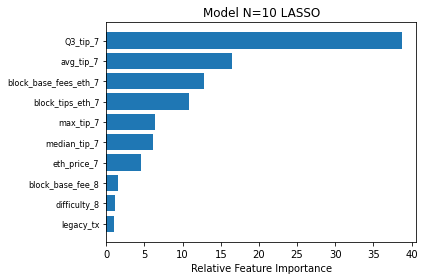

In [ ]:
feature_importance = abs(rf.coef_)
total_feature_importance =  feature_importance.sum()
feature_importance = 100.0 * (feature_importance / total_feature_importance)
column_names_ids = np.argsort(feature_importance)
feature_importance = np.array([i for i in feature_importance if i>1])
column_names_ids = column_names_ids[:len(feature_importance)]
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[column_names_ids], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.title('Model N='+str(best_N)+' LASSO')

plt.tight_layout()   
plt.show()

In [ ]:
#### Real data validation ####
# Getting the block info dataset
dataset_validation = pd.read_csv('./datasets/dataset_validation.csv')

# Data type and column name transformantions 
dataset_validation = dataset_validation.drop(columns=['block_number'])
dataset_validation = dataset_validation.drop(columns=['Unnamed: 0'])
dataset_validation = dataset_validation.rename(columns={"0.25 Tip (Gwei)":"Q1_tip", "0.75 Tip (Gwei)":"Q3_tip", "AVG Tip (Gwei) ":"avg_tip", "Block Base Fees (ETH)":"block_base_fees_eth", "Block Tips (ETH)":"block_tips_eth", "Max Tip (Gwei)": "max_tip", "Median Tip (Gwei)": "median_tip", "Min Tip (Gwei)":"min_tip","AVG Tip (Gwei)":"avg_tip", "Legacy TX count":"legacy_tx","TX count":"tx_count"})
dataset_validation['time'] = pd.to_datetime(dataset_validation['time'])
dataset_validation['time'] = dataset_validation['time'].dt.strftime('%Y-%m-%d %H:%M:00')
dataset_validation['time'] = pd.to_datetime(dataset_validation['time'])

In [ ]:
# eth price dataset from Binance
eth_price_validation = pd.read_csv('./datasets/eth_price_validation.csv')

# Data type and column name transformantions 
eth_price_validation['datetime'] = pd.to_datetime(eth_price_validation['datetime'])
eth_price_validation = eth_price_validation[eth_price_validation['datetime'] <= '2022-08-22 08:22:00']
eth_price_validation = eth_price_validation.rename(columns={'datetime': 'time'})
eth_price_validation = eth_price_validation.drop(columns=['Unnamed: 0'])
eth_price_validation = eth_price_validation.drop_duplicates(subset=['time'])

# Join dataset and eth price
ds_aux = dataset_validation.merge(eth_price_validation, on='time', how='left', indicator=True)


# There are gaps in the Binance API, so we get the last known eth price value and we insert that into empty timestamps
empty_values = ds_aux[ds_aux['_merge'] == 'left_only']
for row in empty_values.iterrows():
    i = 1
    price = 0
    while price == 0:
        if math.isnan(ds_aux.loc[row[0]-i]['eth_price']):
            i=i+1
        else:
            price=ds_aux.loc[row[0]-i]['eth_price']
    ds_aux.at[row[0],'eth_price'] = price


eth_price_validation

,time,eth_price
0,2022-08-07 01:50:00,1677.45
1,2022-08-07 01:51:00,1677.47
2,2022-08-07 01:52:00,1676.72
3,2022-08-07 01:53:00,1676.46
4,2022-08-07 01:54:00,1676.78
...,...,...
995,2022-08-07 18:25:00,1709.43
996,2022-08-07 18:26:00,1709.94
997,2022-08-07 18:27:00,1710.10
998,2022-08-07 18:28:00,1710.45


In [ ]:
dataset_validation = ds_aux
dataset_validation = dataset_validation.drop(columns=['_merge'])
# Drop empty blocks with no tip data 
dataset_validation = dataset_validation.dropna()
dataset_validation = dataset_validation.drop(columns=['total_difficulty'])

In [ ]:
# Drop not relevant columns
dataset_validation = dataset_validation.drop(columns=['time','number'])

dataset_validation = reorder_dataset(dataset_validation,best_N)

dataset_validation = dataset_validation.drop(columns = ['block_base_fee', 'difficulty', 'gas_limit', 'gas_used', 'size', 'Q1_tip',
                            'Q3_tip', 'avg_tip', 'block_base_fees_eth', 'block_tips_eth', 'max_tip', 'median_tip','eth_price'])

#### Drop blocks without full history ####
dataset_validation = dataset_validation.dropna()

/var/folders/v8/qbhfywjj29x_mwp_gsm98j900000gn/T/ipykernel_5853/14653956.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  ds['avg_tip_'+str(i)] = np.nan
/var/folders/v8/qbhfywjj29x_mwp_gsm98j900000gn/T/ipykernel_5853/14653956.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  ds['block_base_fees_eth_'+str(i)] = np.nan
/var/folders/v8/qbhfywjj29x_mwp_gsm98j900000gn/T/ipykernel_5853/14653956.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which ha

In [ ]:
##### N=10 with scaled LASSO#####
y_validation = dataset_validation['min_tip']
X_validation = dataset_validation.drop('min_tip', axis=1)


scaler_validation = StandardScaler()
X_validation = scaler_validation.fit_transform(X_validation)

y_val_pred_lasso = lasso.predict(X_validation)
y_val_pred_lasso = np.maximum(y_val_pred_lasso, 0.)

print('Accuracy for model with info for 10 blocks scaled RF: ', rf.score(X_validation, y_validation))
print('mean_squared_error for model with info for 10 blocks scaled RF: ', mean_squared_error(y_validation, y_val_pred_lasso))
print('mean_absolute_error for model with info for 10 blocks scaled RF: ', mean_absolute_error(y_validation, y_val_pred_lasso))

Accuracy for model with info for 10 blocks scaled LASSO:  -45.76851695957601
mean_squared_error for model with info for 10 blocks scaled LASSO:  434.23395684076564
mean_absolute_error for model with info for 10 blocks scaled LASSO:  1.756665155416477


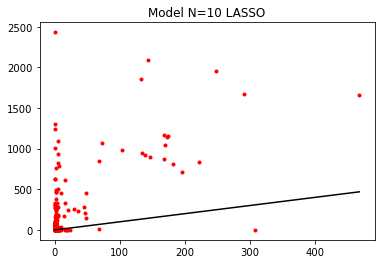

In [ ]:
line=np.linspace(0,np.max(y_validation)+1,len(y_validation)) 

plt.plot(y_validation,y_val_pred_lasso,'r.') # x vs y
plt.plot(line,line,'k-') # identity line

plt.title('Model N='+str(best_N)+' RF')


plt.show()

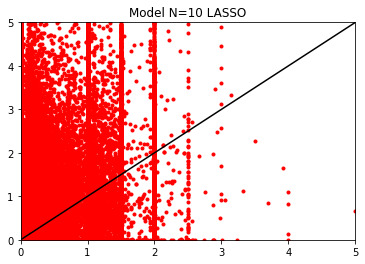

In [50]:
line=np.linspace(0,np.max(y_validation)+1,len(y_validation)) 

plt.plot(y_validation,y_val_pred_lasso,'r.') # x vs y
plt.plot(line,line,'k-') # identity line

plt.title('Model N='+str(best_N)+' RF')
plt.xlim(0,5)
plt.ylim(0,5)

plt.show()

In [67]:
y_val_array = np.array(y_validation)
lower_values=0
for i in range(0,len(y_val_array)):
    if y_val_pred_lasso[i] <= y_val_array[i]:
        lower_values=lower_values+1

print("Amount of predicted min tip that wouldn't be enough to go through for N=10 log:" , lower_values)
print("Percetage of predicted min tip that wouldn't be enough to go through for N=10 log: ", (lower_values/len(y_val_array)*100), "%")

Amount of predicted min tip that wouldn't be enough to go through for N=10 log: 32387
Percetage of predicted min tip that wouldn't be enough to go through for N=10 log:  33.722056205162374 %
